In [3]:
#Importing necessary libraries

#importing data handling libraries
import pandas as pd
import numpy as np
from collections import OrderedDict
from pandasql import sqldf


#importing data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#importing statistical libraries
import scipy.stats as sc
from statsmodels.stats.outliers_influence import variance_inflation_factor

#importing data preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA


#importing machine learning libraries
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor


#importing validation and model selection libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error


#importing libraries to handle warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_personal = pd.read_excel('Medibuddy insurance data personal details.xlsx')
df_insurance = pd.read_csv('Medibuddy Insurance Data Price.csv')

In [5]:
df_insurance

,Policy no.,age,sex,bmi,charges in INR
0,PLC156898,19,female,27.900,16884.92400
1,PLC156907,18,male,33.770,1725.55230
2,PLC156916,28,male,33.000,4449.46200
3,PLC156925,33,male,22.705,21984.47061
4,PLC156934,32,male,28.880,3866.85520
...,...,...,...,...,...
1333,PLC168895,50,male,30.970,10600.54830
1334,PLC168904,18,female,31.920,2205.98080
1335,PLC168913,18,female,36.850,1629.83350
1336,PLC168922,21,female,25.800,2007.94500


In [6]:
df_insurance.drop(['Policy no.'], axis=1, inplace=True)
df_personal.drop(['Policy no.'], axis=1, inplace=True)

In [7]:
df_full = df_insurance

In [8]:
#Label encoding
le = LabelEncoder()
df_insurance['sex'] = le.fit_transform(df_insurance['sex'])
df_personal['region'] = le.fit_transform(df_personal['region'])
df_personal['smoker'] = le.fit_transform(df_personal['smoker'])

In [9]:
#Looking at the descriptive statistics to get the better understanding of the data

def custom_summary(df):

    result =[]
    
    for col in list(df.columns):
        
        #Looking at the statistical parameters
        
        stats = OrderedDict({"featureName":col,
                            "count":df[col].count(),
                            "datatype":df[col].dtype,
                            "min":df[col].min(),
                            "Q1":df[col].quantile(0.25),
                            "Q2":df[col].quantile(0.5),
                            "Q3":df[col].quantile(0.75),
                            "Q4":df[col].quantile(1.0),
                            "mean":df[col].mean(),
                            "stdv":df[col].std(),
                            "var":df[col].var(),
                            "kurt":df[col].kurt(),
                            "skew":df[col].skew(),
                            "range":df[col].max() - df[col].min(),
                            "IQR": df[col].quantile(0.75) - df[col].quantile(0.25)
                            })
        
        # Checking the skewness of the data
        
        if df[col].skew()<-1.0:
            label = "Highly negatively skewed"
        elif -1.0<df[col].skew()<-0.5:
            label = "moderately negatively skewed"
        elif -0.5<df[col].skew()<0.5:
            label = "fairly symmetric"
        elif 0.5<df[col].skew()<1.0:
            label = "moderately positively skewed"
        else:
            label = "Highly positively skewed"
            
        stats['skewness comment'] = label;
        
        
        #Outliers identification
        
        upper_limit = stats['Q3'] + (1.5*stats['IQR'])
        lower_limit = stats['Q1'] - (1.5*stats['IQR'])
        if len([x for x in df[col] if x <lower_limit or x>upper_limit ]) > 0:
            outliers_label = "Has outliers"
        else:
            outliers_label = "No outliers"
        
        stats['Outlier comment'] = outliers_label        
        stats['number of outliers'] = len([x for x in df[col] if x <lower_limit or x>upper_limit ])
        
        #Calculating the outliers percentage
        
        stats['Percentage of outliers'] = stats['number of outliers']*100/stats['count']
        
        result.append(stats)
    resultdf = pd.DataFrame(data=result)
    return resultdf
    

In [10]:
custom_summary(df_insurance)

,featureName,count,datatype,min,Q1,Q2,Q3,Q4,mean,stdv,var,kurt,skew,range,IQR,skewness comment,Outlier comment,number of outliers,Percentage of outliers
0,age,1338,int64,18.0000,27.00000,39.000,51.000000,64.00000,39.207025,14.049960,1.974014e+02,-1.245088,0.055673,46.00000,24.000000,fairly symmetric,No outliers,0,0.000000
1,sex,1338,int32,0.0000,0.00000,1.000,1.000000,1.00000,0.505232,0.500160,2.501596e-01,-2.002557,-0.020951,1.00000,1.000000,fairly symmetric,No outliers,0,0.000000
2,bmi,1338,float64,15.9600,26.29625,30.400,34.693750,53.13000,30.663397,6.098187,3.718788e+01,-0.050732,0.284047,37.17000,8.397500,fairly symmetric,Has outliers,9,0.672646
3,charges in INR,1338,float64,1121.8739,4740.28715,9382.033,16639.912515,63770.42801,13270.422265,12110.011237,1.466524e+08,1.606299,1.515880,62648.55411,11899.625365,Highly positively skewed,Has outliers,139,10.388640


In [11]:
#Finding out the correlation with the target (correlation matrix)
def corr_variables(data, target):
    ind_var = data.drop([target], axis=1).columns
    corr_res =[]
    for col in ind_var:
        corr_res.append(data[target].corr(data[col]))
    res_df = pd.DataFrame([ind_var, corr_res], index=['variable','correlation']).T.sort_values('correlation', ascending = False)
    
    return res_df

In [12]:
corr_variables(df_full, 'charges in INR')

,variable,correlation
0,age,0.299008
2,bmi,0.198341
1,sex,0.057292


<AxesSubplot:>

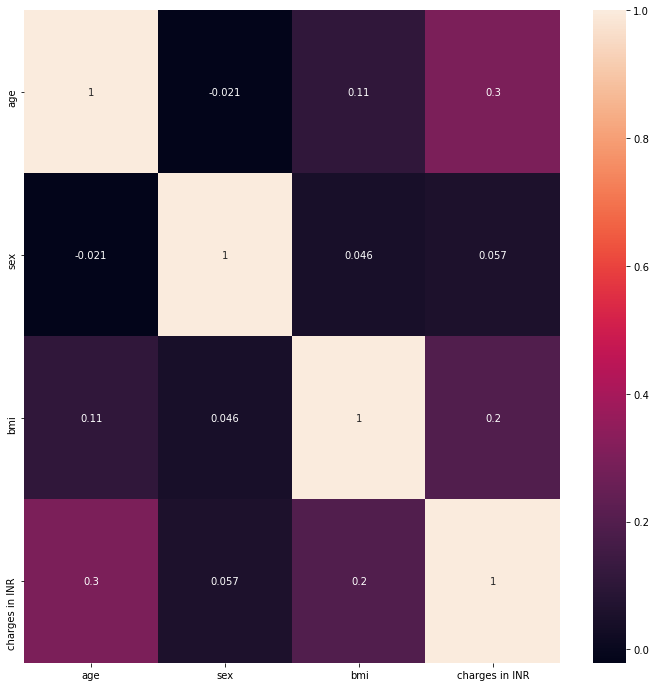

In [13]:
# Multicolinearity check (with heat map)
corr = df_full.corr()
fig = plt.subplots(figsize=(12,12))
sns.heatmap(corr, annot=True)

In [14]:
def vif_colinearity(data, target):
    ind_var = data.drop([target], axis=1)
    vif = pd.DataFrame()
    vif['vif factor'] = [variance_inflation_factor(ind_var.values,i) for i in range(ind_var.shape[1])]
    vif['variable'] = ind_var.columns
    
    return vif.sort_values('vif factor', ascending=False)

In [15]:
vif_colinearity(df_full, 'charges in INR') #Why VIF of BMI is highe rthan the age?

,vif factor,variable
2,8.261823,bmi
0,7.467095,age
1,1.982607,sex


In [16]:
# As the above variables has have multicolinearity, we will apply PCA
def apply_pca(x):
    col = []
    n_comp = len(x.columns)
    
    #applying standard scalar before PCA
    x = StandardScaler().fit_transform(x)
    
    #Applying PCA in for floop
    for i in range(1,n_comp+1):
        pca = PCA(n_components=i)
        p_comp = pca.fit_transform(x)
        evr = np.cumsum(pca.explained_variance_ratio_)
        n_components = i
        if evr[i-1]>0.9:
            break
    
    print("The explained variance ratio is: ", evr)
    
    #creating data frame
    for j in range(1,n_components+1):
        col.append('pc'+str(j))
        
    result = pd.DataFrame(data = p_comp, columns=col)
    return result

In [17]:
pca_df = apply_pca(df_full.drop('charges in INR', axis=1))

The explained variance ratio is:  [0.37081833 0.70907584 1.        ]


In [18]:
pca_df = pca_df.join(df_full[['charges in INR']], how='left')

In [19]:
pca_df

,pc1,pc2,pc3,charges in INR
0,-1.466156,-0.448655,0.972515,16884.92400
1,-0.471136,1.536960,0.966843,1725.55230
2,-0.085632,1.255438,0.423659,4449.46200
3,-1.066932,0.911464,-0.953892,21984.47061
4,-0.383044,1.064661,-0.219035,3866.85520
...,...,...,...,...
1333,0.722669,0.629199,-0.808843,10600.54830
1334,-1.037573,-0.339648,1.466873,2205.98080
1335,-0.453509,-0.238554,2.017063,1629.83350
1336,-1.619600,-0.544864,0.646704,2007.94500


In [20]:
vif_colinearity(pca_df, 'charges in INR')

,vif factor,variable
0,1.0,pc1
1,1.0,pc2
2,1.0,pc3


In [21]:
def train_n_test_split(data, target, test_size=0.3):
    x=data.drop(target, axis=1)
    y=df_full[[target]]
    
    return train_test_split(x,y, test_size=test_size,random_state=50)

In [22]:
def build_model(model_name, estimator, data, target):
    x_train, x_test, y_train, y_test = train_n_test_split(data, target)
    estimator.fit(x_train, y_train)
    y_pred = estimator.predict(x_test)
    rmsc = np.sqrt(mean_squared_error(y_test, y_pred))
    r2score = r2_score(y_test, y_pred)
    
    temp = [model_name, rmsc, r2score]
    return temp

In [23]:
build_model('Linear Regression', LinearRegression(), pca_df, 'charges in INR')

['Linear Regression', 11896.503980513824, 0.1371750011648425]

In [24]:
def multiple_models(data, target):
    
    #column names in empty data frame
    col_names = ['Model name', 'rmsc', 'r2score']
    
    #Creating a empty data frame
    resultdf = pd.DataFrame(columns=col_names)
    
    resultdf.loc[len(resultdf)] = build_model('Linear regression', LinearRegression(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Lasso', Lasso(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Ridge', Ridge(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Decision tree', DecisionTreeRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('KNN', KNeighborsRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('SVM regressor', SVR(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('randon forests', RandomForestRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Ada boost', AdaBoostRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('Gboost', GradientBoostingRegressor(), data, target)
    
    resultdf.loc[len(resultdf)] = build_model('xGboost', XGBRegressor(), data, target)
    
    return resultdf
    
    

In [25]:
multiple_models(pca_df, 'charges in INR')

,Model name,rmsc,r2score
0,Linear regression,11896.503981,0.137175
1,Lasso,11896.497318,0.137176
2,Ridge,11896.823684,0.137129
3,Decision tree,16075.991912,-0.575577
4,KNN,12582.331974,0.034824
5,SVM regressor,13637.592576,-0.133860
6,randon forests,12796.879066,0.001629
7,Ada boost,12060.537935,0.113217
8,Gboost,12324.139611,0.074029
9,xGboost,13391.607089,-0.093325


In [26]:
#Cross validation score
def cv_score(x,y,fold=10):
    
    #defining cross validation score
    score_lr = cross_val_score(LinearRegression(),x,y,cv=fold)
    score_lasso = cross_val_score(Lasso(),x,y,cv=fold)
    score_ridge = cross_val_score(Ridge(),x,y,cv=fold)
    score_DT = cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_KNN = cross_val_score(KNeighborsRegressor(),x,y,cv=fold)
    score_svm = cross_val_score(SVR(),x,y,cv=fold)
    score_RF = cross_val_score(RandomForestRegressor(),x,y,cv=fold)
    score_ADR = cross_val_score(AdaBoostRegressor(),x,y,cv=fold)
    score_GBR = cross_val_score(GradientBoostingRegressor(),x,y,cv=fold)
    score_xGBR = cross_val_score(XGBRegressor(),x,y,cv=fold)
    
    model_names = ['Linear Regression', 'Lasso regression', 'Ridge', 'Decision tree', 'kNeighbors', 'SVM', 'Random forests', 'Ada boost', 'Gradient boost', 'xGBoost']
    scores = [score_lr, score_lasso, score_ridge, score_DT, score_KNN, score_svm, score_RF, score_ADR, score_GBR, score_xGBR]
    
    result = []
    
    for i in range(0,len(model_names)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        n_names = model_names[i]
        temp = [n_names, score_mean, score_std]
        result.append(temp)
    
    result_df = pd.DataFrame(data=result, columns=['model_names', 'average score', 'standard deviation'])
    
    return result_df
    

In [27]:
cv_score(pca_df.drop('charges in INR', axis=1), pca_df[['charges in INR']], 10)

,model_names,average score,standard deviation
0,Linear Regression,0.109313,0.045289
1,Lasso regression,0.109314,0.045269
2,Ridge,0.109321,0.045247
3,Decision tree,-0.905666,0.168970
4,kNeighbors,-0.020398,0.073987
5,SVM,-0.105223,0.030414
6,Random forests,-0.048485,0.072992
7,Ada boost,-0.102461,0.127055
8,Gradient boost,0.066226,0.061225
9,xGBoost,-0.134554,0.099941


In [28]:
df_full.rename(columns = {'charges in INR':'charges'}, inplace = True)

<AxesSubplot:xlabel='age', ylabel='charges'>

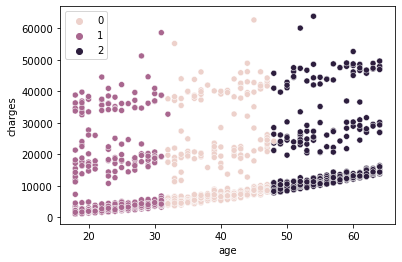

In [38]:
#applying clustering in order to see if the accuracy increases

x=df_full.drop('charges', axis=1)
y=df_full[['charges']]

from sklearn.cluster import KMeans

labels = KMeans(n_clusters=3, random_state=100).fit_predict(x)
sns.scatterplot(x=x.age, y=y.charges, hue=labels)

In [39]:
def clusters_in_data(x,target, labels):
    columns = list(set(list(x.columns))-set(target))
    r = int(len(columns)/2)
    
    
    
    if r%2 == 0:
        r=r
    else:
        r=r+1
        
    
    f, ax = plt.subplots(r,2, figsize=(15,15))
    a=0
    for row in range(0,r):
        for col in range(0,2):
            if a != len(columns):
                ax[row][col].scatter(x[target], x[columns[a]], c=labels)
                ax[row][col].set_xlabel(target)
                ax[row][col].set_ylabel(columns[a])
                a=a+1

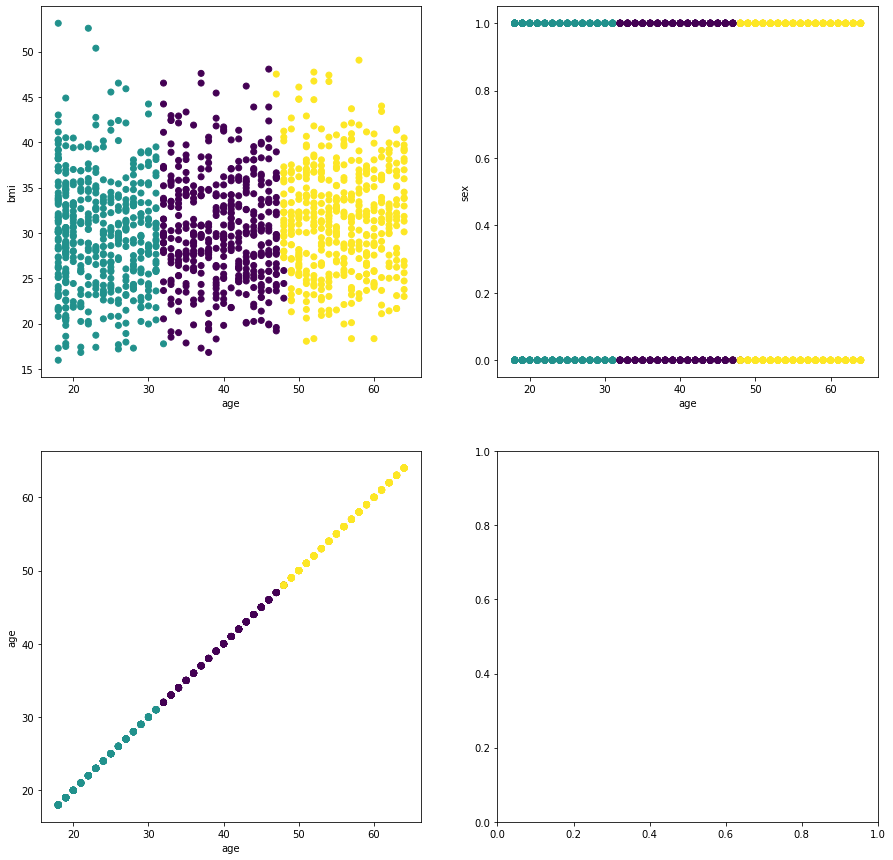

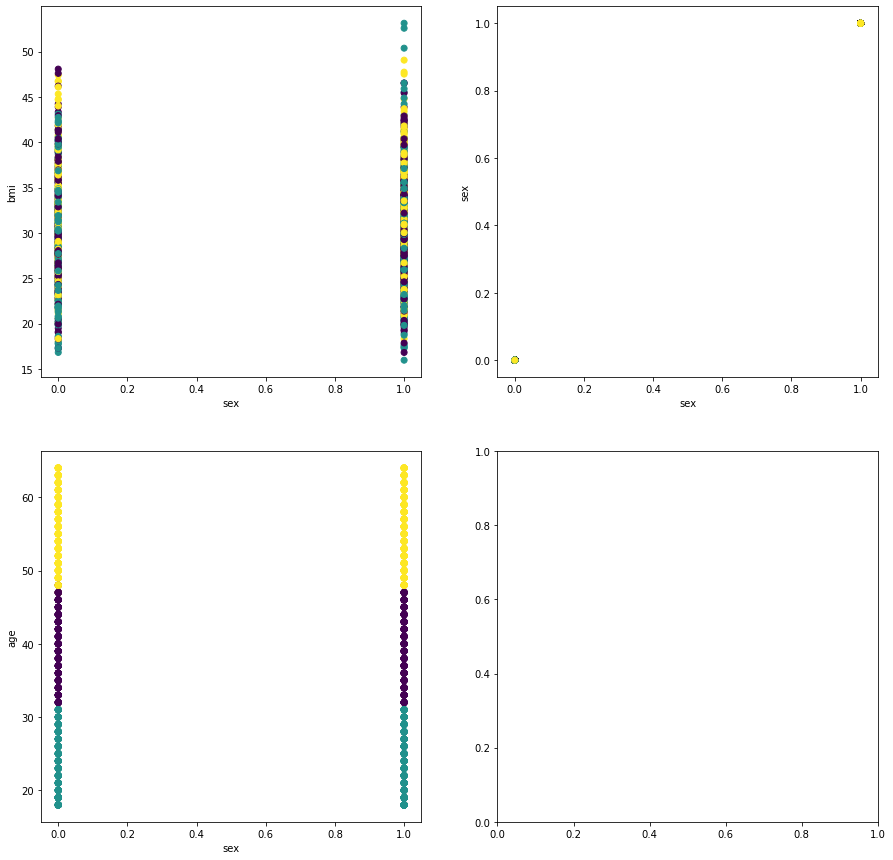

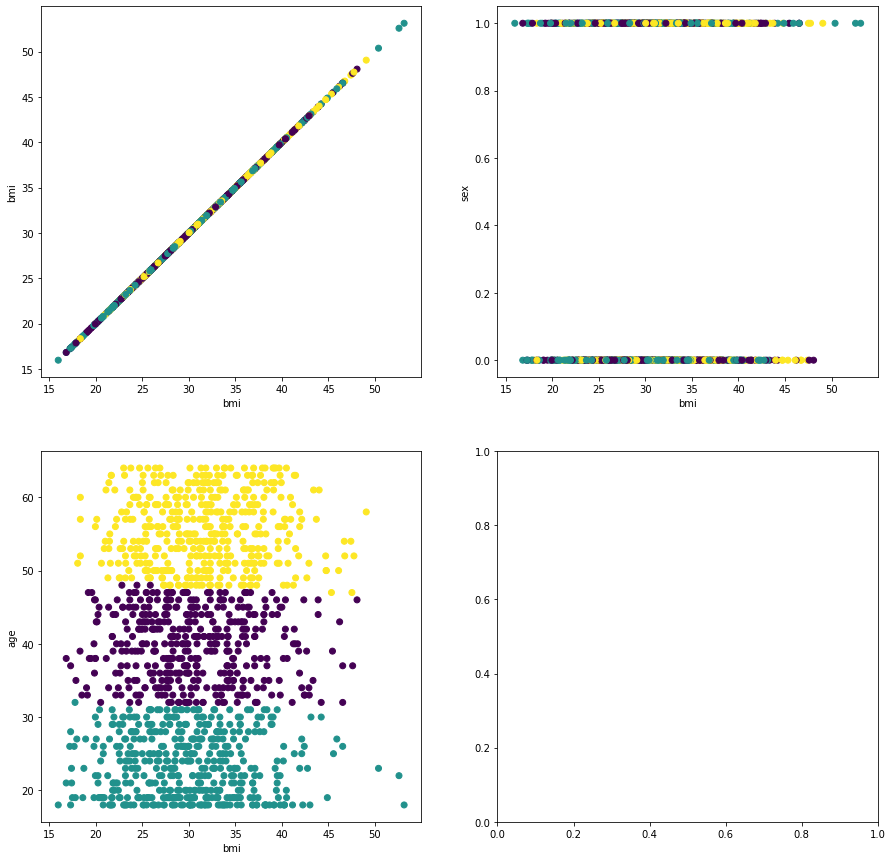

In [40]:
for col in x.columns:
    clusters_in_data(x, col, labels)

In [41]:
clustered_df = df_full.join(pd.DataFrame(labels, columns=['labels']), how='left')

In [42]:
clustered_df

,age,sex,bmi,charges,labels
0,19,0,27.900,16884.92400,1
1,18,1,33.770,1725.55230,1
2,28,1,33.000,4449.46200,1
3,33,1,22.705,21984.47061,0
4,32,1,28.880,3866.85520,0
...,...,...,...,...,...
1333,50,1,30.970,10600.54830,2
1334,18,0,31.920,2205.98080,1
1335,18,0,36.850,1629.83350,1
1336,21,0,25.800,2007.94500,1


In [43]:
new_feature = clustered_df.groupby('labels')['age'].agg(['mean', 'median'])

In [44]:
new_feature

,mean,median
labels,,
0,39.738824,40
1,23.440678,23
2,55.569161,55


In [45]:
clustered_df = clustered_df.merge(new_feature, on='labels', how='left')

In [46]:
cv_score(clustered_df.drop('charges', axis=1), clustered_df[['charges']], 10)

,model_names,average score,standard deviation
0,Linear Regression,0.111147,0.046157
1,Lasso regression,0.111165,0.046134
2,Ridge,0.111160,0.046135
3,Decision tree,-0.937751,0.188155
4,kNeighbors,-0.052126,0.078531
5,SVM,-0.106187,0.031094
6,Random forests,-0.128755,0.101541
7,Ada boost,-0.059251,0.100714
8,Gradient boost,-0.001660,0.075385
9,xGBoost,-0.283237,0.203128
